<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/.addixo/6_Generation_Classification_Interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [77]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/addixo_final_dataset_fs_db.csv', parse_dates=['dates'],  index_col='dates',infer_datetime_format=True)

In [78]:
df.drop(['label'], axis=1, inplace=True)

In [4]:
def create_data(series, prev_instances = 4):
 
    X_train_1 = pd.DataFrame(series).astype('float64')
    X_train_temp = X_train_1.shift(1)
    y_label = X_train_1.shift(-1)
    
    data = pd.concat([X_train_temp, X_train_1, y_label], axis=1)
    
    for r in range(prev_instances-2):
      X_train_temp = X_train_temp.shift(1)
      data = pd.concat([X_train_temp, data], axis=1)
    data.dropna(inplace = True)
    data.reset_index(drop = True, inplace = True)
    # print(data.head(10))
    X = data.iloc[:, 0:-1].values 
    y = data.iloc[:,-1].values 
        
    data.columns = [*data.columns[:-1], 'y']
    
    return data, X, y

In [5]:
from keras.models import load_model
from keras.utils.vis_utils import plot_model

filepath = '/content/gdrive/MyDrive/Datascience/PFE/Models/transformer-best.h5'
model = load_model(filepath, compile=False)

In [6]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  
    mae = np.mean(np.abs(forecast - actual))    
    rmse = np.mean((forecast - actual)**2)**.5  

    return mape, mae, rmse

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Generation of the new data

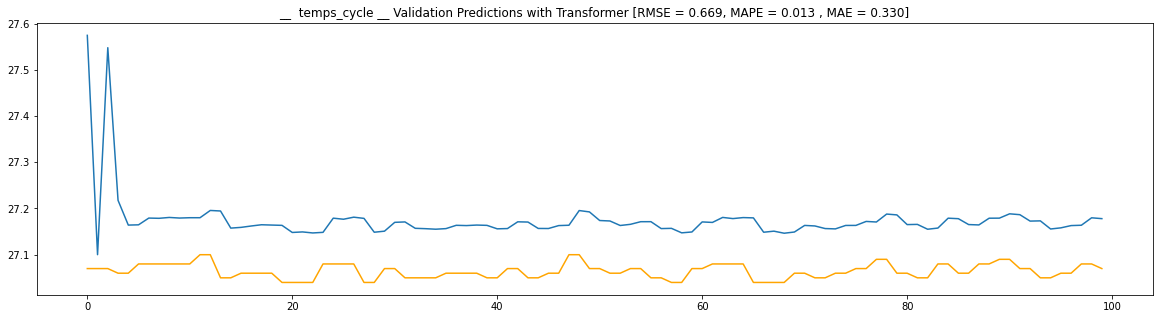

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


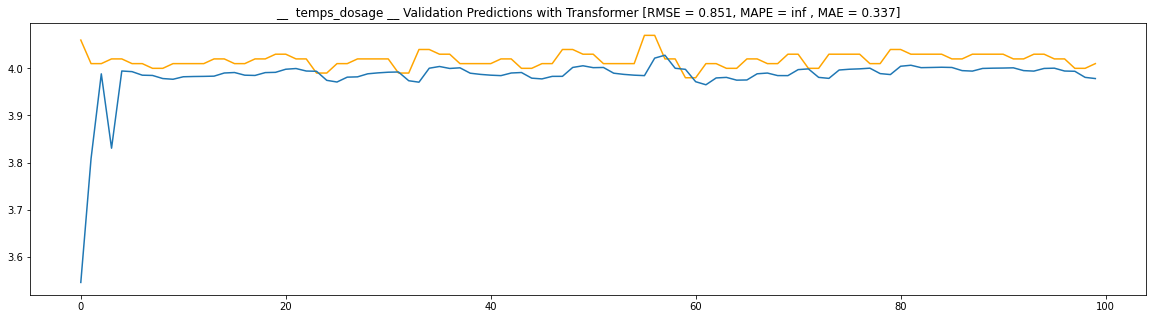

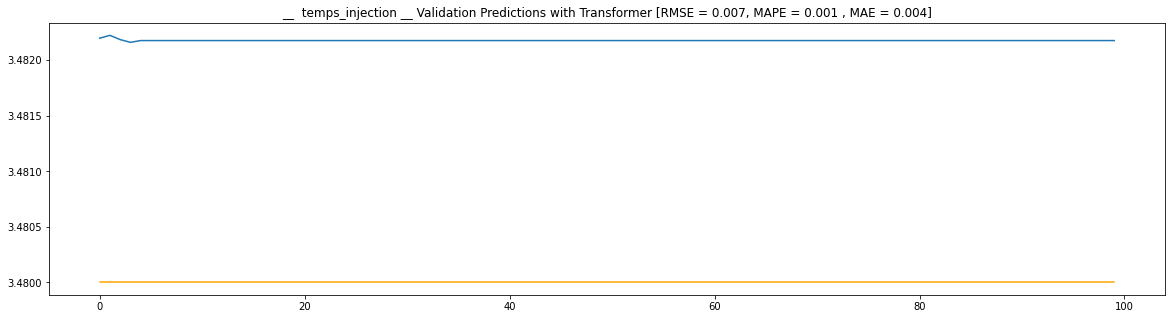

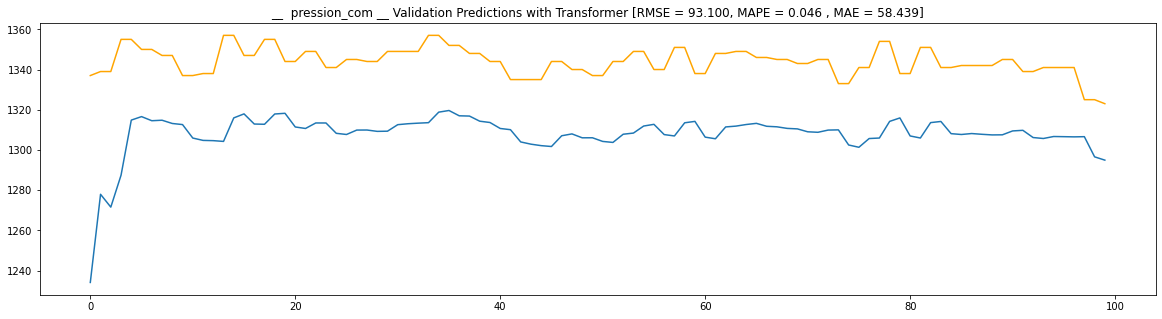

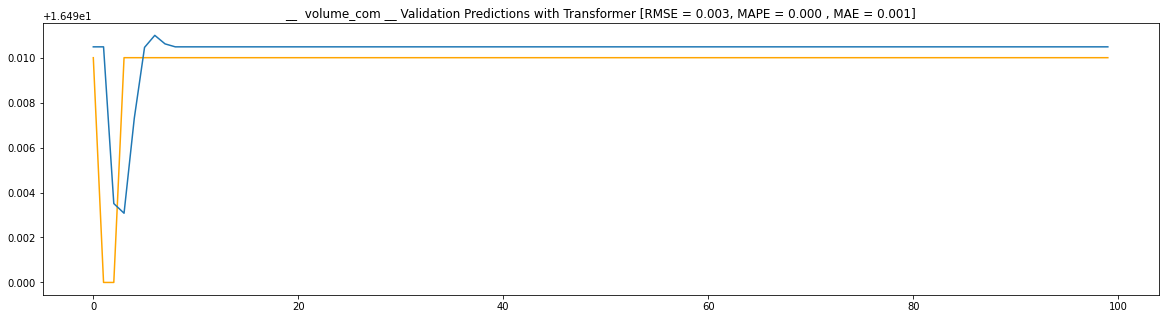

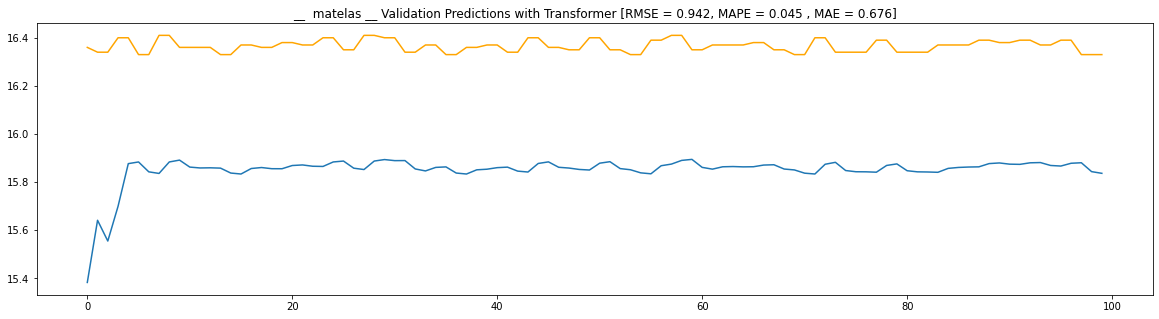

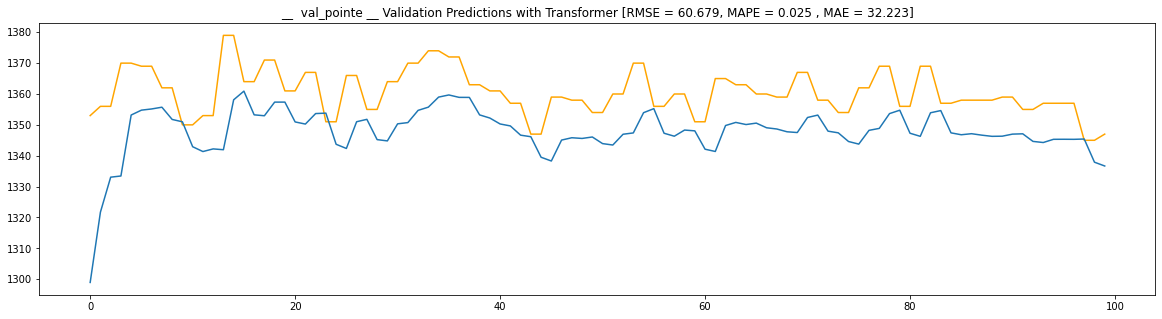

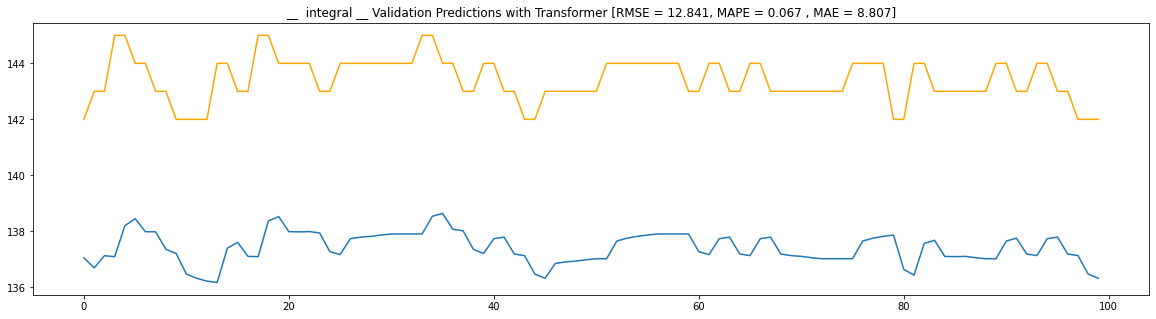

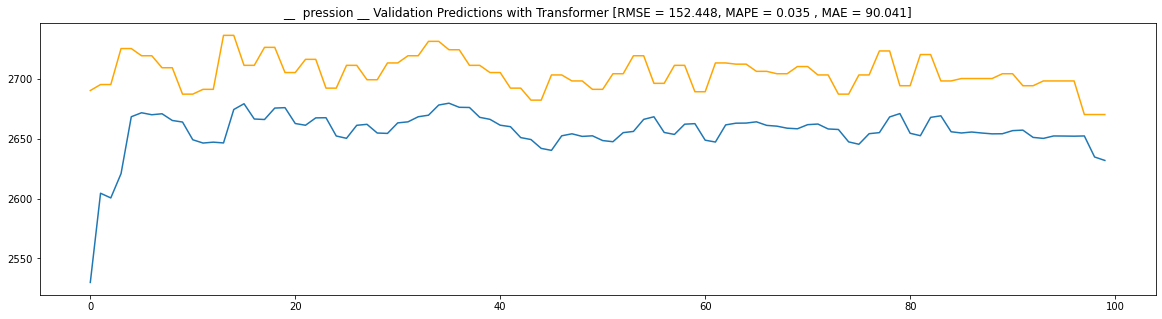

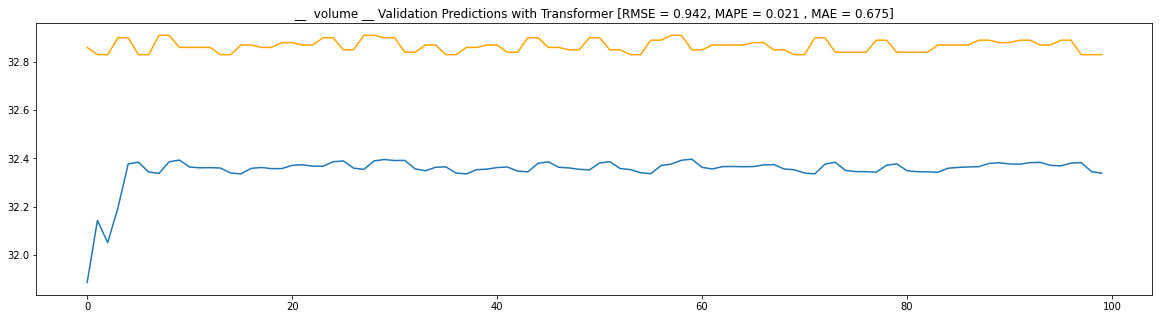

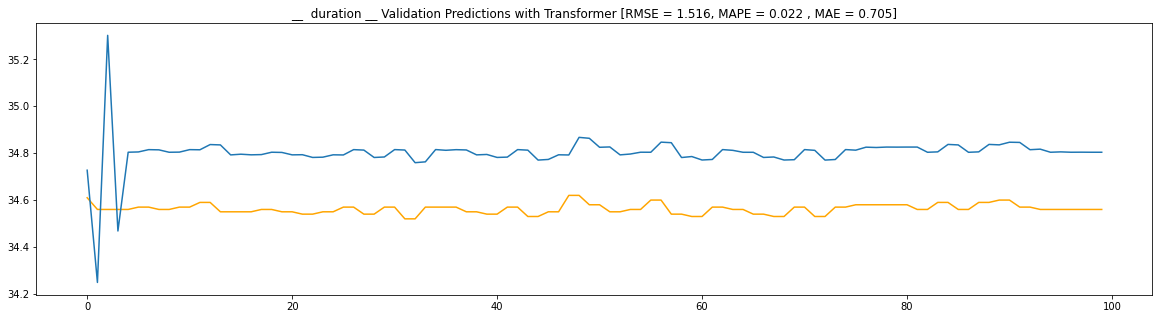

In [7]:
from pandas._libs.lib import count_level_2d
from sklearn.preprocessing import MinMaxScaler

new_data = []
predictions = []
final_df = pd.DataFrame(new_data)
i = -1

for col in df.columns:
  # Normalization
  values = df[[col]].values

  # Normalization
  scaler = MinMaxScaler()
  scaled_data = scaler.fit_transform(values)

  WINDOW_SIZE = 5

  time_series = scaled_data;
  data, X, y = create_data(time_series, prev_instances = WINDOW_SIZE)

  # 70% 15% 15%

  X_train_tr, y_train_tr = X[:57153], y[:57153]
  X_test, y_test = X[57153:69400], y[57153:69400]
  X_val, y_val = X[69400:], y[69400:]

  import tensorflow as tf 

  BATCH_SIZE = 256
  BUFFER_SIZE = 10000

  train_univariate = tf.data.Dataset.from_tensor_slices((X_train_tr, y_train_tr))
  train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

  val_univariate = tf.data.Dataset.from_tensor_slices((X_val, y_val))
  val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

  # reshape input to be 3D [samples, timesteps, features]
  X_train_tr = X_train_tr.reshape((X_train_tr.shape[0], WINDOW_SIZE,1))
  X_test = X_test.reshape((X_test.shape[0], WINDOW_SIZE, 1))
  X_val = X_val.reshape((X_val.shape[0], WINDOW_SIZE, 1))
      

  y_pred_val = model.predict(np.asarray(X_val).astype('float32'))
  Inverse_y_pred_val = scaler.inverse_transform(y_pred_val)

  Inverse_y_val = y_val.reshape(-1,1)
  Inverse_y_val = scaler.inverse_transform(Inverse_y_val)
  
  Inverse_X_val = X_val.reshape(-1,1)
  Inverse_X_val = scaler.inverse_transform(Inverse_X_val)

  
  new_col = []
  for val in Inverse_y_pred_val:
    new_col.append(val[0])

  final_df.insert(i+1,col ,new_col)

  mape, mae, rmse = forecast_accuracy(Inverse_y_pred_val, Inverse_y_val)

  fig, ax = plt.subplots(figsize=(20,5))
  plt.plot(Inverse_y_val[0:100], color='orange')
  plt.plot(Inverse_y_pred_val[0:100])
  plt.title("__  %s __ Validation Predictions with Transformer [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (col, rmse, mape, mae) )
  plt.show()

In [8]:
def create_time_steps(length):
    return list(range(-length, 0))
    
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i]);
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step');
    
    return plt

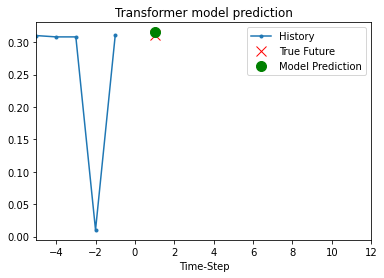

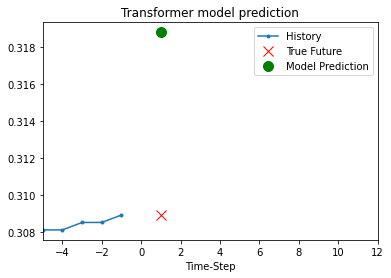

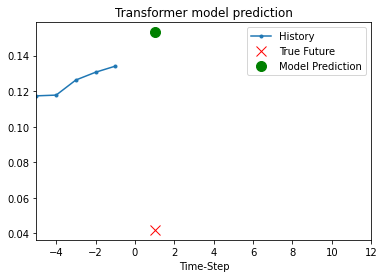

In [9]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    model.predict(x)[0]], 1, 'Transformer model prediction')
    plot.show()

## 2. Classification

In [10]:
for col in final_df:
  final_df[col] =final_df[col].apply(lambda x: round(x, 3))

In [12]:
import pickle

filename = '/content/gdrive/MyDrive/Datascience/PFE/addixo_knn_classifier.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [13]:
#for testing
if {'label prediction'}.issubset(final_df.columns): 
  final_df.drop('label prediction', axis=1, inplace=True)

mms = MinMaxScaler()
X_val = mms.fit_transform(final_df)
result = loaded_model.predict(X_val)

final_df.insert(0,"label prediction" ,result)
final_df.head()

,label prediction,duration,volume,pression,integral,val_pointe,matelas,volume_com,pression_com,temps_injection,temps_dosage,temps_cycle
0,1,34.727,31.886,2530.026,137.054,1298.943,15.383,16.500,1234.082,3.482,3.546,27.574
1,1,34.249,32.143,2604.392,136.698,1321.724,15.641,16.500,1277.931,3.482,3.808,27.100
2,1,35.302,32.051,2600.474,137.131,1333.052,15.555,16.494,1271.547,3.482,3.988,27.548
3,1,34.468,32.194,2620.732,137.097,1333.433,15.699,16.493,1287.432,3.482,3.830,27.218
4,1,34.804,32.377,2668.160,138.201,1353.187,15.877,16.497,1314.841,3.482,3.994,27.164


In [17]:
all_dfs = [final_df]

Accuracy:  0 98.76863253402462


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       932
           1       0.99      0.99      0.99      2154

    accuracy                           0.99      3086
   macro avg       0.99      0.98      0.99      3086
weighted avg       0.99      0.99      0.99      3086

ROC_AUC_SCORE  0.9974779928349692
_______________________________________________ 



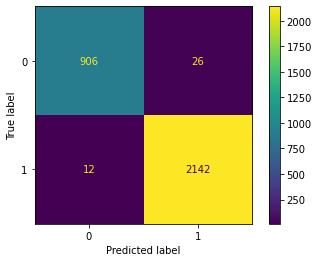

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#initialisation
model = 0
i = 0

for df in all_dfs:
  if 'dates' in df.columns:
    X = df.drop(['label prediction', 'dates'], axis=1)
    y = df['label prediction']
  else:
    X = df.drop(['label prediction'], axis=1)
    y = df['label prediction']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  grid_params = {
      'n_neighbors' : [3,5,11,19], # Always odd numbers to avaid ties
      'weights': ['uniform', 'distance'],
      'metric': ['euclidean', 'manhattan']
  }

  grid = GridSearchCV(
      KNeighborsClassifier(),
      grid_params,
      cv = 5,
      n_jobs = -1 #use all resources
  )

  grid_results = grid.fit(X_train, y_train)
  best_params = [grid_results.best_params_['metric'],grid_results.best_params_['n_neighbors'],grid_results.best_params_['weights']]

  #KNN with the best params
  model = KNeighborsClassifier(n_neighbors=best_params[1], 
                            weights=best_params[2], 
                            metric=best_params[0], 
                            n_jobs=-1)
  model.fit(X_train.values, y_train.values)
  y_test_hat=model.predict(X_test.values) 
  test_accuracy=accuracy_score(y_test,y_test_hat)*100


  print('Accuracy: ',i,test_accuracy)
  ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);  
  y_pred = model.predict(X_test.values)

  print(classification_report(y_test,y_pred))

  y_pred_proba = model.predict_proba(X_test.values)[:,1]
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

  print('ROC_AUC_SCORE ',roc_auc_score(y_test,y_pred_proba))
  print('_______________________________________________ \n')
  i = i + 1
  break

## 3. Interpretation

Intuitively, an explanation is a local linear approximation of the model's behaviour. While the model may be very complex globally, it is easier to approximate it around the vicinity of a particular instance. While treating the model as a black box, we perturb the instance we want to explain and learn a sparse linear model around it, as an explanation.

In [ ]:
!pip install lime

In [38]:
import random
from sklearn.model_selection import train_test_split

X = final_df.drop(['label prediction'], axis=1)
y = final_df['label prediction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [39]:
import lime
from lime import lime_tabular

interpretor = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    mode='classification'
)

In [40]:
random_sample = X_test.iloc[random.randrange(0, (len(X_test)-1))]

exp = interpretor.explain_instance(
    data_row=random_sample,
    predict_fn=model.predict_proba,
)

exp.show_in_notebook(show_table=True)

In [ ]:
exp.as_list()

In [ ]:
f = open("report.txt", "a")
for i in range(0, len(exp.as_list())):
  f.write((exp.as_list())[i][0] +"\n")

f.write("\nEND FILE")
f.close()

#open and read the file after the appending:
f = open("report.txt", "r")
print(f.read())

In [86]:
# selecting rows based on condition
rslt_df = df.loc[(df['pression'] > 2683.21) & (df['integral'] > 137.91) & (df['val_pointe'] > 1361.66)
& (df['pression_com'] > 1321.95) & (df['volume_com'] <= 16.50) &  (df['duration'] <= 34.84)
&  (df['matelas'] > 15.87) &  (df['temps_dosage'] > 4.03) & ((df['temps_injection'] > 3.49) & (df['temps_injection'] <= 3.52)) 
&  ((df['temps_cycle'] > 27.07) & (df['temps_cycle'] <= 27.14)) ]

In [ ]:
#for testing
if {'label prediction'}.issubset(rslt_df.columns): 
  rslt_df.drop('label prediction', axis=1, inplace=True)

mms = MinMaxScaler()
X_val = mms.fit_transform(rslt_df)
result = loaded_model.predict(X_val)

rslt_df.insert(0,"label prediction" ,result)
rslt_df

In [ ]:
df_test = df[0:len(rslt_df)]

#for testing
if {'label prediction'}.issubset(df_test.columns): 
  df_test.drop('label prediction', axis=1, inplace=True)

mms = MinMaxScaler()
X_val = mms.fit_transform(df_test)
result = loaded_model.predict(X_val)

df_test.insert(0,"label prediction" ,result)
df_test.head()

Total: 2811
label prediction
0    2583
1     228
dtype: int64


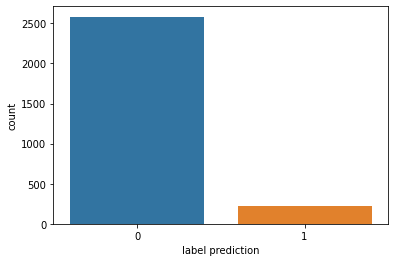

In [93]:
import seaborn as sns

print("Total:", len(df_test))
print(df_test.groupby(['label prediction']).size())
sns.countplot(x ='label prediction', data = df_test)

Total: 2811
label prediction
0    1618
1    1193
dtype: int64


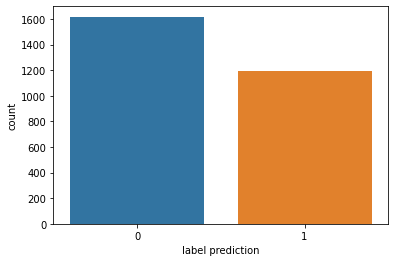

In [94]:
import seaborn as sns

print("Total:", len(rslt_df))
print(rslt_df.groupby(['label prediction']).size())
sns.countplot(x ='label prediction', data = rslt_df)